In [1]:
import csv
import itertools
from time import time

import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from sklearn import metrics

training_data = 'data/OLIDv1.0/olid-training-v1.0.tsv'
test_data = 'data/OLIDv1.0/testset-levela.tsv'
test_labels = 'data/OLIDv1.0/labels-levela.csv'
hashtags = 'data/olid_segmentations.tsv'
bad_words_list = 'data/bad-words.txt'
bad_words_trimmed_list = 'data/trimmed-bad-words.txt'

tk = TweetTokenizer(preserve_case=False)

In [2]:
start = time()
with open(training_data, encoding='utf-8') as f:
    raw = csv.reader(f, delimiter='\t')
    x_train_raw = []
    y_train = []
    for r in raw:
        x_train_raw.append(r[1])
        y_train.append(0 if r[2] == 'NOT' else 1)
    x_train_raw = x_train_raw[1:]
    y_train = y_train[1:]
    
with open(test_data, encoding='utf-8') as f:
    raw = csv.reader(f, delimiter='\t')
    test_ids = []
    x_test_raw = []
    for r in raw:
        test_ids.append(r[0])
        x_test_raw.append(r[1])
    test_ids = [int(i) for i in test_ids[1:]]
    x_test_raw = x_test_raw[1:]
        
with open(test_labels, encoding='utf-8') as f:
    raw = csv.reader(f, delimiter=',')
    y_test = []
    for r in raw:
        y_test.append(0 if r[1] == 'NOT' else 1)
    
segmentations = {}
for line in open(hashtags, encoding='utf-8'):
    terms = [x.strip().lower() for x in line.split('\t')]
    hashtag, segmentation = terms[0], terms[1]
    segmentations[hashtag] = segmentation
    
bad_words = [line.strip() for line in open(bad_words_list)]
trimmed_bad_words = [line.strip() for line in open(bad_words_trimmed_list)]
    
print('Loaded data in %.2fs' % (time() - start))

Loaded data in 0.16s


In [3]:
def report(y, y_hat, title):
    results = [
        metrics.accuracy_score(y, y_hat),
        metrics.precision_score(y, y_hat),
        metrics.recall_score(y, y_hat),
        metrics.f1_score(y, y_hat, average='weighted'),
        metrics.f1_score(y, y_hat, average='macro')
    ]
    print(5 * '%-8s' % ('acc', 'p', 'r', 'f1w', 'f1m'))
    print('%.4f  %.4f  %.4f  %.4f  %.4f\n' % tuple(results))
    
    cm = metrics.confusion_matrix(y, y_hat)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm, classes=('Inoffensive', 'Offensive'), title=title)
    plt.savefig('graphs/' + title + '.png', bbox_inches='tight', pad_inches=0.4)
    plt.show()

def tokenize(x):
    tokens = []
    for token in tk.tokenize(x):
        if token[0] == '#' and token[1:] in segmentations:
            sequence = segmentations[token[1:]].split()
        else:
            sequence = [token]
            
        for word in sequence:
            tokens.append(word)
    return tokens
                                         
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    https://stackoverflow.com/questions/48817300/sklearn-plot-confusion-matrix-combined-across-trainingtest-sets
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=45)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

david-lr-val.txt
acc     p       r       f1w     f1m     
0.8081  0.7193  0.5125  0.7971  0.7362



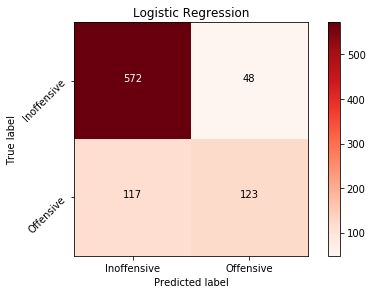

jp-lr-val.txt
acc     p       r       f1w     f1m     
0.8128  0.8435  0.4042  0.7884  0.7143



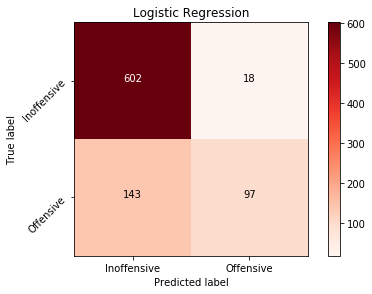

svm-val.txt
acc     p       r       f1w     f1m     
0.8081  0.7622  0.4542  0.7908  0.7229



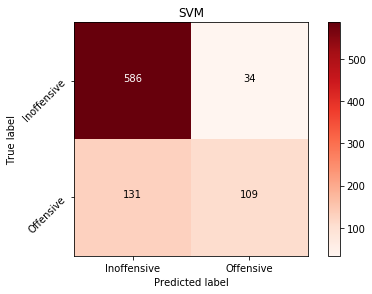

xgb-val.txt
acc     p       r       f1w     f1m     
0.8000  0.6789  0.5375  0.7922  0.7333



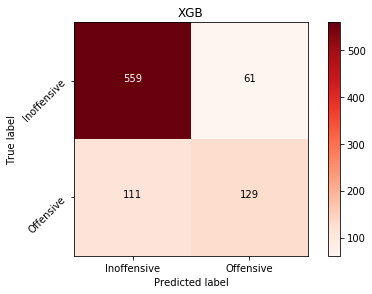

cnn-val.txt
acc     p       r       f1w     f1m     
0.7942  0.7333  0.4125  0.7734  0.6982



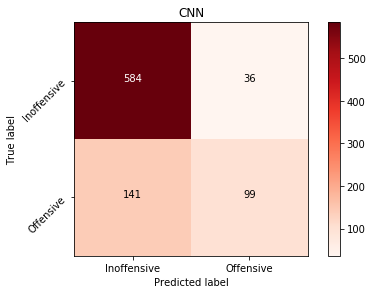

gru-val.txt
acc     p       r       f1w     f1m     
0.8023  0.6306  0.7042  0.8055  0.7625



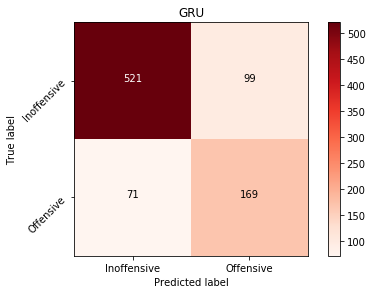

stack-val.txt
acc     p       r       f1w     f1m     
0.8267  0.7758  0.5333  0.8156  0.7594



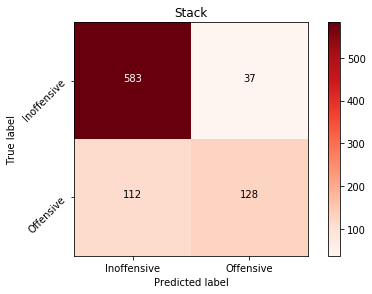

most common label (0)
acc     p       r       f1w     f1m     
0.7209  0.0000  0.0000  0.6040  0.4189



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


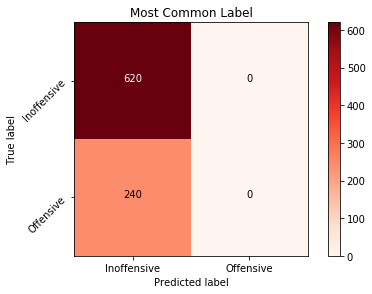

CMU full bad words list
acc     p       r       f1w     f1m     
0.6721  0.4379  0.6167  0.6858  0.6326



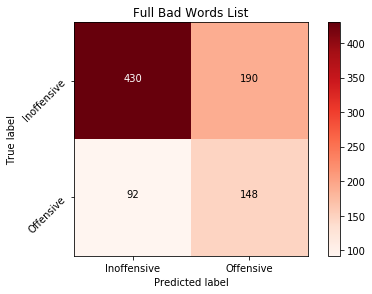

Trimmed bad words list
acc     p       r       f1w     f1m     
0.7628  0.6098  0.4167  0.7473  0.6700



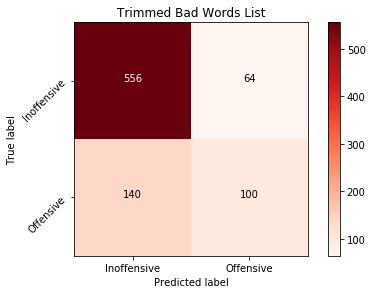

In [4]:
files = [
    ('david-lr-val.txt', 'Logistic Regression'),
    ('jp-lr-val.txt', 'Logistic Regression'),
    ('svm-val.txt', 'SVM'),
    ('xgb-val.txt', 'XGB'),
    ('cnn-val.txt', 'CNN'),
    ('gru-val.txt', 'GRU'),
    ('stack-val.txt', 'Stack')
]

for filename, title in files:
    print(filename)
    y_hat = [int(y) for y in open('predictions/' + filename)]
    report(y_test, y_hat, title)

print('most common label (0)')
y_hat = np.zeros(860)
report(y_test, y_hat, 'Most Common Label')

x_test_tokenized = [tokenize(x) for x in x_test_raw]
print('CMU full bad words list')
y_hat = []
for x in x_test_tokenized:
    bad = False
    for token in x:
        if token in bad_words:
            bad = True
    y_hat.append(1 if bad else 0)
report(y_test, y_hat, 'Full Bad Words List')

print('Trimmed bad words list')
y_hat = []
for x in x_test_tokenized:
    bad = False
    for token in x:
        if token in trimmed_bad_words:
            bad = True
    y_hat.append(1 if bad else 0)
report(y_test, y_hat, 'Trimmed Bad Words List')

In [8]:
sum(y_hat)

164

In [6]:
len(bad_words)

1383

In [7]:
sum(y_test)

240